### Utilities

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
#Find x samples of the desired target and x that are not, create df from results with fps 
#this data will be leveraged for OHE
def getChunks(label, col, df, typ, sz):
    a = df[df[col] == label].sample(sz)
    b = df[df[col] != label].sample(sz)
    c = pd.concat([a,b])
    c['fp']= c['smiles'].apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))
    if typ: # make new col for label data
        c['is']= c['target'].apply(lambda x: x == label)
    return c
 

In [2]:
from rdkit.Chem import AllChem

def getChunks2(label, col, df, typ, sz):
    a = df[df[col] == label].sample(sz)
    b = df[df[col] != label].sample(sz)
    c = pd.concat([a,b])
    #GetMorganFingerprintAsBitVect(m1,2,nBits=1024)
    c['fp2']= c['smiles'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect\
                                (Chem.MolFromSmiles(x),2,nBits=1024))
    c['fp']= c['smiles'].apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))
    if typ: # make new col for label data
        c['is']= c['target'].apply(lambda x: x == label)
    return c

In [3]:
# load json and create model function 
from keras.models import model_from_json

def loadModel(x):
    json_file = open(x+'_model3.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(x+"_model3.h5")
    return loaded_model

C:\Users\juan\anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#Get binary data from desired column
def prepBinData(df,col):
    return np.array(df[col]).astype(np.uint8)

In [5]:
#Prep binary array from rdkit fp, can specify to add target columns
def prepBinAryData(df, typ):
    
    if(typ == 'aff'): # using fp to predict affinity type
        
        y = np.empty((0, 2048))
        for index, row in df.get(['fp']).iterrows():
            x = np.array(row['fp']) #ie [1,0,0,0...] n =2048
            y = np.append(y, [np.array(x)], axis=0)
            
    elif (typ == 'mo'):
        
        y1 = np.empty((0, 2048))
        for index, row in df.get(['fp']).iterrows():
            x1 = np.array(row['fp']) #ie [1,0,0,0...] n =2048
            y1 = np.append(y1, [np.array(x1)], axis=0)
        
        y2 = np.empty((0, 1024))
        for index, row in df.get(['fp2']).iterrows():
            x2 = np.array(row['fp2']) #ie [1,0,0,0...] n =2048
            y2 = np.append(y2, [np.array(x2)], axis=0)
            
        y = np.concatenate((y1, y2),1)
            
    else: # using fp+ affinity type to predict target
        
        y = np.empty((0,3))
        for index, row in df.get(['HA','LA','OTH']).iterrows():
            x = np.array([]) #ie [1,0,0,0...] n = 0
            x = np.insert(x, 0, row['HA'])#ie [0]
            x = np.insert(x, 0, row['LA'])#ie [0]
            x = np.insert(x, 0, row['OTH'])#ie [0]
            y = np.append(y, [np.array(x)], axis=0)
    
    return y.astype(np.uint8)

In [6]:
#Collect metrics from rdkit scoring module, print AUC, and Bedroc score, return array of enrichment factors.
from rdkit.ML.Scoring import Scoring

def getMetrics(df, col, model, tag):
    truee = prepBinData(df,col)
    results = np.array([])
    raw = np.array([])
    for i in range(df.shape[0]):
        x = model.predict(prepBinAryData(df[i:i+1],tag))
        raw = np.insert(raw, len(raw), x)
        if x > .5:
            x = 1
        else:
            x =0
        results = np.insert(results, len(results), x)
    
    rdk =np.concatenate([results.reshape(len(results),1),truee.reshape(len(results),1), \
                         raw.reshape(len(raw),1)], axis=1)
    fracs = [.2,.4,.6,.8]
    rankd = rdk[rdk[:,2].argsort()[::-1]]
    print('Area under the ROC curve: ' +str(Scoring.CalcAUC(rankd, 1)))
    print('BedROC score: ' +str(Scoring.CalcBEDROC(rankd, 1,20)))
    return Scoring.CalcEnrichment(rankd,1,fracs)
        
    

----------

## Loading ChEMBL Data

Reference: https://smu.box.com/s/smqmwlef0yehpieicwxqdr99k7f9ru04 (Links to an external site.)
    

In [7]:


f = open('C:\\Users\\juan\\Downloads\\dataCHEMBL\\dataCHEMBL\\data.csv', 'r', encoding="ISO-8859-1")
lines = f.readlines()
f.close()


flis = [] # will have [id, ic50_val, unit, target, smiles] 

for line in lines[1:]: # first line contains the headers (therefore skiped)
    lis = line.strip().split(',')

    if len(lis) < 36:
        continue
    
    
    #print (lis[0], lis[3], lis[8], lis[36])
    # [id, ic50_val, unit, target, smiles]

    flis.append([lis[0], lis[3], lis[4], lis[19], lis[8], lis[36]])
    #break

# I have no idea why python adds \x00 to each string
# Therefoe I removed it

for i in range (len(flis)):
    flis[i] = [j.replace('\x00','') for j in flis[i]]
    flis[i] = [j.replace('"','') for j in flis[i]]

# Some of the data have smiles or IC50 missing
# So I removed them as well
list = []
for i in flis:
    if len(i[1]) != 0 and len(i[-1]) != 0:
        #print (i)
        list.append(i)

X, t, y,  w = [], [], [], []
for i in list:
    if i[2] == 'nM':
        if len(i[-1]) == 0 or len(i[-2]) ==0 or len(i[1]) ==0:
            print ('Thers a problem !!')
        X.append(i[-1])
        t.append(i[-2])
        y.append(i[1])
        w.append(i[-3])
    

# smiles is the string representation of each ligand
# target is the protein where ligand binds (treat it as different schools)
# ic50 is the score
np.savez('data.npz', smiles=X, target=t, ic50=y, molecular_weights=w)



## Filtering Top 100 Targets

In [8]:
data = np.load('C:\\Users\\juan\\Downloads\\dataCHEMBL\\dataCHEMBL\\data.npz')

##which targets (protein) binded together and which did not
##Top 100 targets, sorting by Molecular Weights
smiles = data['smiles']
df = pd.DataFrame(data=smiles,columns=['smiles'])
df['target'] = data['target']
t100 = df['target'].value_counts().head(100).index.tolist()
df['ic50']=data['ic50'].astype(float)

Getting the top 100 targets based on the number of assays that have them as a target.

In [9]:
#idx100: The chembl id of the top 100 targets
df['molecular_weights'] = data['molecular_weights']
df['molecular_weights'] = df['molecular_weights'].apply(lambda x: x if(x.isnumeric())  else 'N/A' )
df['valid_smile'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None )
df['top_100'] = df['target'].apply(lambda x: x in t100)
df['HA'] = df['ic50'].apply(lambda x: 1 if x <= 300 else 0)
df['LA']= df['ic50'].apply(lambda x: 1 if x > 10000 else 0)
df['OTH']= df.apply(lambda row: 1 if (not (row.LA or row.HA)) else 0, axis=1)
dfFiltered = df[(df['valid_smile']) & (df['top_100'])]

## Sample filtered data

In [10]:
dfFiltered.to_pickle("./fltrd.pkl")


## Checkpoint 1, preprocessing is complete

In [11]:
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle

up_dfFil = shuffle(pd.read_pickle("./fltrd.pkl"))

t100 = up_dfFil['target'].value_counts().head(100).index.tolist()

### Primary analysis: Create binary classification model for each affinity type (low, high and other)

### Determing Hyperparameters 

#### Different models and combinations of layers were considered while placing an emphasis on the trainability of each combination on a compute-power constrained machine(ie personal machine).  The two options considered was a network that used a LTSM approach and one that used a convolution approach, which we found using the same alpha and momentum values that the convolution model converged significantly faster and was less susceptible to premature stabilization. Other HPs worth mentioning are the optimizer, hidden layers and dropout rate.   The two optimizers considered included ADAM and SGD, and as expected the ADAM optimizer performed better with a small number of epochs compared to the SGD method, we suspect the SGD approach may yield better results but would require significantly more training epochs and/or data. For the sake of injecting each model with a shared hidden layer, the position in the model sequence of which the shared layer was placed was crucial. We believe, if placed too early onto the sequence, the benefit of using a shared layer may become obsolete as the shared layer’s weights would converge in a manner that simply copies the input information of the previous layer onto the next  in order to enable other more discriminatory layers in each respective model. Whereas placing the shared layer too close to the output layer, the training of each model to convergence may prove to be prohibitively time consuming. We believe this might be the case because each model will train each of their previous layers for a specific output but then have to consolidate the shared layer between the two models for robustness. Considering these two theories, we placed a dropout layer  between the shared layer and the output layer, allowing each model to determine which activations from the shared layer it wants to use for its classification task which we used .3 for the dropout rate which was empirically determined to be optimal for the purpose of this lab. 

Sources:

https://github.com/aajanki/sequence-classification/blob/master/sequence_classifiers/cnn.py


https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/


In [12]:
#inline plots bring in their own dependencies, forcing the need to reimport dependecies for analysis,
#I am sure there is a smarter way of doing this.
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K


mdict = {}
accs = []
losss = []
cols = ['HA','LA', 'OTH']
#shared layer across models
shared = Dense(250)
for tag in cols:
    inputs = Input(shape=(2048,), name='fps')
    x = Dropout(.3)(inputs)
    x = Reshape((64,32,))(x)
    x = Convolution1D(100, 10,padding='valid',activation='relu',strides=1)(x)
    x = GlobalMaxPooling1D()(x)
    x = shared(x)
    x = Dropout(.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    
    mdict[tag] = Model(inputs=inputs, outputs=outputs)
    mdict[tag].compile(loss='binary_crossentropy', optimizer='ADAM', metrics=['binary_accuracy'])
    t = getChunks(1,tag, up_dfFil,0,500) # get chunk of data where tag == 1, of size 500 and 500 of not, w/o new column
    t = shuffle(t)
    splt = int(len(t)*.8)
    t_train = t[:splt] #80
    t_test = t[splt:]#20
    trgt = tag
    mdict[tag].fit(prepBinAryData(t_train,'aff'), prepBinData(t_train, trgt), epochs=100, verbose=1)
    score = mdict[tag].evaluate(prepBinAryData(t_test, 'aff'), prepBinData(t_test, trgt), verbose=1)
    print(score)
    losss.append(score[0])
    accs.append(score[1])
    del x



Epoch 1/100
800/800 [==============================] - 1s 1ms/step - loss: 0.8618 - binary_accuracy: 0.5225
Epoch 2/100
800/800 [==============================] - 0s 354us/step - loss: 0.6305 - binary_accuracy: 0.6475
Epoch 3/100
800/800 [==============================] - 0s 351us/step - loss: 0.5721 - binary_accuracy: 0.7112
Epoch 4/100
800/800 [==============================] - 0s 387us/step - loss: 0.5485 - binary_accuracy: 0.7300
Epoch 5/100
800/800 [==============================] - 0s 366us/step - loss: 0.5292 - binary_accuracy: 0.7338
Epoch 6/100
800/800 [==============================] - 0s 389us/step - loss: 0.5115 - binary_accuracy: 0.7488
Epoch 7/100
800/800 [==============================] - 0s 417us/step - loss: 0.4880 - binary_accuracy: 0.7625
Epoch 8/100
800/800 [==============================] - 0s 440us/step - loss: 0.4415 - binary_accuracy: 0.7975 0s - loss: 0.4466 - binary_accuracy: 0.8
Epoch 9/100
800/800 [==============================] - 0s 388us/step - loss: 0.44

800/800 [==============================] - 0s 396us/step - loss: 0.0691 - binary_accuracy: 0.9800
Epoch 48/100
800/800 [==============================] - 0s 371us/step - loss: 0.0603 - binary_accuracy: 0.9725
Epoch 49/100
800/800 [==============================] - 0s 364us/step - loss: 0.0714 - binary_accuracy: 0.9788
Epoch 50/100
800/800 [==============================] - 0s 367us/step - loss: 0.0808 - binary_accuracy: 0.9675
Epoch 51/100
800/800 [==============================] - 0s 387us/step - loss: 0.0673 - binary_accuracy: 0.9763
Epoch 52/100
800/800 [==============================] - 0s 367us/step - loss: 0.0725 - binary_accuracy: 0.9725
Epoch 53/100
800/800 [==============================] - 0s 369us/step - loss: 0.0906 - binary_accuracy: 0.9700
Epoch 54/100
800/800 [==============================] - 0s 374us/step - loss: 0.0984 - binary_accuracy: 0.9600
Epoch 55/100
800/800 [==============================] - 0s 395us/step - loss: 0.1418 - binary_accuracy: 0.9438
Epoch 56/100
8

800/800 [==============================] - 0s 376us/step - loss: 0.1449 - binary_accuracy: 0.9475
Epoch 94/100
800/800 [==============================] - 0s 398us/step - loss: 0.1562 - binary_accuracy: 0.9475
Epoch 95/100
800/800 [==============================] - 0s 378us/step - loss: 0.1745 - binary_accuracy: 0.9312
Epoch 96/100
800/800 [==============================] - 0s 368us/step - loss: 0.1810 - binary_accuracy: 0.9237
Epoch 97/100
800/800 [==============================] - 0s 381us/step - loss: 0.2272 - binary_accuracy: 0.9150
Epoch 98/100
800/800 [==============================] - 0s 407us/step - loss: 0.1827 - binary_accuracy: 0.9312
Epoch 99/100
800/800 [==============================] - 0s 378us/step - loss: 0.1613 - binary_accuracy: 0.9425
Epoch 100/100
200/200 [==============================] - 0s 527us/step
[0.9474741649627686, 0.665]


### Looking at our validation results, it appears there is a timing component at play, as the order of which the models get trained plays a role on the tuning of the shared layer. One might use a "tug of war" analogy to describe this phenomenon, where each model is competing to fit the shared layer for its purposes, taking away from the other two models. For our secondary analysis, we theorize that this can be overcome by adding additional epochs but randomizing the order of which the models get trained for “n”  batches. To achieve this, we set up a for loop with n number of batches to iterate  over randomizing the order of training each step while also gathering a new randomize set of training data for each training iteration. 

In [13]:
for i in range(10):
    print("Batch "+str(i))
    mdls = shuffle(cols)
    for tag in mdls:
        print("Training: "+str(tag))
        t = getChunks(1,tag, up_dfFil,0,100) # get chunk of data where tag == 1, of size 500 and 500 of not, w/o new column
        t = shuffle(t)
        splt = int(len(t)*.8)
        t_train = t[:splt] #80
        t_test = t[splt:]#20
        trgt = tag
        mdict[tag].fit(prepBinAryData(t_train,'aff'), prepBinData(t_train, trgt), epochs=10, verbose=1)
        score = mdict[tag].evaluate(prepBinAryData(t_test, 'aff'), prepBinData(t_test, trgt), verbose=1)
        print(score)
        losss.append(score[0])
        accs.append(score[1])

Batch 0
Training: OTH
Epoch 1/10
160/160 [==============================] - 0s 421us/step - loss: 1.1694 - binary_accuracy: 0.6125
Epoch 2/10
160/160 [==============================] - 0s 412us/step - loss: 0.9346 - binary_accuracy: 0.6063
Epoch 3/10
160/160 [==============================] - 0s 443us/step - loss: 0.8075 - binary_accuracy: 0.6813
Epoch 4/10
160/160 [==============================] - 0s 466us/step - loss: 0.6584 - binary_accuracy: 0.6750
Epoch 5/10
160/160 [==============================] - 0s 477us/step - loss: 0.6149 - binary_accuracy: 0.7000
Epoch 6/10
160/160 [==============================] - 0s 396us/step - loss: 0.5211 - binary_accuracy: 0.7375
Epoch 7/10
160/160 [==============================] - 0s 511us/step - loss: 0.5344 - binary_accuracy: 0.7250
Epoch 8/10
160/160 [==============================] - 0s 452us/step - loss: 0.4755 - binary_accuracy: 0.7438
Epoch 9/10
160/160 [==============================] - 0s 474us/step - loss: 0.4318 - binary_accuracy: 0.80

160/160 [==============================] - 0s 387us/step - loss: 0.5528 - binary_accuracy: 0.7188
Epoch 9/10
160/160 [==============================] - 0s 353us/step - loss: 0.5205 - binary_accuracy: 0.7500
Epoch 10/10
40/40 [==============================] - 0s 224us/step
[0.9194363594055176, 0.5]
Training: LA
Epoch 1/10
160/160 [==============================] - 0s 365us/step - loss: 0.4378 - binary_accuracy: 0.8000
Epoch 2/10
160/160 [==============================] - 0s 381us/step - loss: 0.4409 - binary_accuracy: 0.8063
Epoch 3/10
160/160 [==============================] - 0s 380us/step - loss: 0.3526 - binary_accuracy: 0.8500
Epoch 4/10
160/160 [==============================] - 0s 380us/step - loss: 0.3544 - binary_accuracy: 0.8187
Epoch 5/10
160/160 [==============================] - 0s 380us/step - loss: 0.2868 - binary_accuracy: 0.8937
Epoch 6/10
160/160 [==============================] - 0s 385us/step - loss: 0.2983 - binary_accuracy: 0.8750
Epoch 7/10
160/160 [=============

160/160 [==============================] - 0s 380us/step - loss: 0.3946 - binary_accuracy: 0.8063
Epoch 5/10
160/160 [==============================] - 0s 531us/step - loss: 0.3758 - binary_accuracy: 0.8438
Epoch 6/10
160/160 [==============================] - 0s 410us/step - loss: 0.3890 - binary_accuracy: 0.8187
Epoch 7/10
160/160 [==============================] - 0s 393us/step - loss: 0.3543 - binary_accuracy: 0.8063
Epoch 8/10
160/160 [==============================] - 0s 371us/step - loss: 0.3500 - binary_accuracy: 0.8375
Epoch 9/10
160/160 [==============================] - 0s 363us/step - loss: 0.3436 - binary_accuracy: 0.8312
Epoch 10/10
40/40 [==============================] - 0s 204us/step
[0.44186771512031553, 0.775]
Training: OTH
Epoch 1/10
160/160 [==============================] - 0s 374us/step - loss: 0.6908 - binary_accuracy: 0.6750
Epoch 2/10
160/160 [==============================] - 0s 393us/step - loss: 0.6670 - binary_accuracy: 0.6625
Epoch 3/10
160/160 [=========

Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'shuffle', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


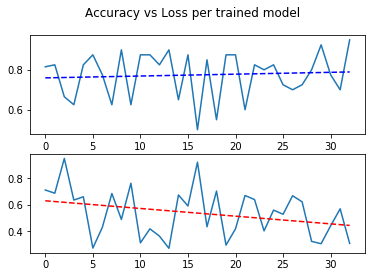

In [14]:
%pylab inline
import matplotlib.pyplot as plt

x = range(len(accs))

fig, axs = plt.subplots(2)
fig.suptitle('Accuracy vs Loss per trained model')

z = np.polyfit(x, accs, 1)
p = np.poly1d(z)
z1 = np.polyfit(x, losss, 1)
p1 = np.poly1d(z1)

axs[0].plot(x, accs)
axs[0].plot(x,p(x),"b--")
axs[1].plot(x, losss)
axs[1].plot(x,p1(x),"r--")

### It apears our shared layer is still struggling to balance the inputs from the three networks, namely the OTH model. We will repeat the process without it.

In [16]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K


mdict = {}
accs = []
losss = []
cols = ['HA','LA']
#shared layer across models
shared = GlobalMaxPooling1D()
for tag in cols:
    inputs = Input(shape=(2048,), name='fps')
    x = Reshape((64,32,))(inputs)
    x = Dropout(.3)(x)
    x = Convolution1D(100, 10,padding='valid',activation='relu',strides=1)(x)
    x = shared(x)
    x = Dense(250)(x)
    x = Dropout(.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    
    mdict[tag] = Model(inputs=inputs, outputs=outputs)
    mdict[tag].compile(loss='binary_crossentropy', optimizer='ADAM', metrics=['binary_accuracy'])
    t = getChunks(1,tag, up_dfFil,0,500) # get chunk of data where tag == 1, of size 500 and 500 of not, w/o new column
    t = shuffle(t)
    splt = int(len(t)*.8)
    t_train = t[:splt] #80
    t_test = t[splt:]#20
    trgt = tag
    mdict[tag].fit(prepBinAryData(t_train,'aff'), prepBinData(t_train, trgt), epochs=100, verbose=1)
    score = mdict[tag].evaluate(prepBinAryData(t_test, 'aff'), prepBinData(t_test, trgt), verbose=1)
    print(score)
    losss.append(score[0])
    accs.append(score[1])
    del x



Epoch 1/100
800/800 [==============================] - 1s 2ms/step - loss: 0.7967 - binary_accuracy: 0.5225
Epoch 2/100
800/800 [==============================] - 0s 371us/step - loss: 0.6760 - binary_accuracy: 0.6050 0s - loss: 0.6799 - binary_accuracy: 0.618
Epoch 3/100
800/800 [==============================] - 0s 294us/step - loss: 0.5947 - binary_accuracy: 0.6837
Epoch 4/100
800/800 [==============================] - 0s 273us/step - loss: 0.5509 - binary_accuracy: 0.7288
Epoch 5/100
800/800 [==============================] - 0s 287us/step - loss: 0.5377 - binary_accuracy: 0.7263
Epoch 6/100
800/800 [==============================] - 0s 268us/step - loss: 0.5022 - binary_accuracy: 0.7538
Epoch 7/100
800/800 [==============================] - 0s 277us/step - loss: 0.4967 - binary_accuracy: 0.7750
Epoch 8/100
800/800 [==============================] - 0s 269us/step - loss: 0.4514 - binary_accuracy: 0.7875
Epoch 9/100
800/800 [==============================] - 0s 294us/step - loss: 0.

800/800 [==============================] - 0s 274us/step - loss: 0.1030 - binary_accuracy: 0.9575
Epoch 48/100
800/800 [==============================] - 0s 276us/step - loss: 0.0716 - binary_accuracy: 0.9750
Epoch 49/100
800/800 [==============================] - 0s 270us/step - loss: 0.0613 - binary_accuracy: 0.9750
Epoch 50/100
800/800 [==============================] - 0s 276us/step - loss: 0.0453 - binary_accuracy: 0.9913
Epoch 51/100
800/800 [==============================] - 0s 269us/step - loss: 0.0858 - binary_accuracy: 0.9662
Epoch 52/100
800/800 [==============================] - 0s 264us/step - loss: 0.0928 - binary_accuracy: 0.9587
Epoch 53/100
800/800 [==============================] - 0s 273us/step - loss: 0.0655 - binary_accuracy: 0.9775
Epoch 54/100
800/800 [==============================] - 0s 277us/step - loss: 0.0620 - binary_accuracy: 0.9775
Epoch 55/100
800/800 [==============================] - 0s 272us/step - loss: 0.0436 - binary_accuracy: 0.9913
Epoch 56/100
8

In [17]:

for i in range(10):
    print("Batch "+str(i))
    mdls = shuffle(cols)
    for tag in mdls:
        print("Training: "+str(tag))
        t = getChunks(1,tag, up_dfFil,0,100) # get chunk of data where tag == 1, of size 500 and 500 of not, w/o new column
        t = shuffle(t)
        splt = int(len(t)*.8)
        t_train = t[:splt] #80
        t_test = t[splt:]#20
        trgt = tag
        mdict[tag].fit(prepBinAryData(t_train,'aff'), prepBinData(t_train, trgt), epochs=10, verbose=1)
        score = mdict[tag].evaluate(prepBinAryData(t_test, 'aff'), prepBinData(t_test, trgt), verbose=1)
        print(score)
        losss.append(score[0])
        accs.append(score[1])

Batch 0
Training: LA
Epoch 1/10
160/160 [==============================] - 1s 4ms/step - loss: 1.0052 - binary_accuracy: 0.7438
Epoch 2/10
160/160 [==============================] - 0s 368us/step - loss: 0.6822 - binary_accuracy: 0.7938
Epoch 3/10
160/160 [==============================] - 0s 330us/step - loss: 0.6684 - binary_accuracy: 0.7562
Epoch 4/10
160/160 [==============================] - 0s 309us/step - loss: 0.6059 - binary_accuracy: 0.8063
Epoch 5/10
160/160 [==============================] - 0s 315us/step - loss: 0.4917 - binary_accuracy: 0.8250
Epoch 6/10
160/160 [==============================] - 0s 342us/step - loss: 0.3007 - binary_accuracy: 0.8625
Epoch 7/10
160/160 [==============================] - 0s 368us/step - loss: 0.2408 - binary_accuracy: 0.9000
Epoch 8/10
160/160 [==============================] - 0s 349us/step - loss: 0.1442 - binary_accuracy: 0.9375
Epoch 9/10
160/160 [==============================] - 0s 380us/step - loss: 0.2367 - binary_accuracy: 0.8875


160/160 [==============================] - 0s 360us/step - loss: 0.2767 - binary_accuracy: 0.8812
Epoch 9/10
160/160 [==============================] - 0s 335us/step - loss: 0.2862 - binary_accuracy: 0.8812
Epoch 10/10
40/40 [==============================] - 0s 99us/step
[0.29006134271621703, 0.9]
Batch 7
Training: LA
Epoch 1/10
160/160 [==============================] - 0s 308us/step - loss: 0.4271 - binary_accuracy: 0.8250
Epoch 2/10
160/160 [==============================] - 0s 312us/step - loss: 0.3903 - binary_accuracy: 0.8250
Epoch 3/10
160/160 [==============================] - 0s 324us/step - loss: 0.3264 - binary_accuracy: 0.8563
Epoch 4/10
160/160 [==============================] - 0s 278us/step - loss: 0.3455 - binary_accuracy: 0.8438
Epoch 5/10
160/160 [==============================] - 0s 299us/step - loss: 0.3411 - binary_accuracy: 0.8625
Epoch 6/10
160/160 [==============================] - 0s 305us/step - loss: 0.3164 - binary_accuracy: 0.8625
Epoch 7/10
160/160 [=====

Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


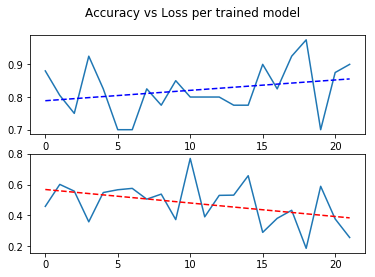

In [18]:
%pylab inline
import matplotlib.pyplot as plt

x = range(len(accs))

fig, axs = plt.subplots(2)
fig.suptitle('Accuracy vs Loss per trained model')

z = np.polyfit(x, accs, 1)
p = np.poly1d(z)
z1 = np.polyfit(x, losss, 1)
p1 = np.poly1d(z1)

axs[0].plot(x, accs)
axs[0].plot(x,p(x),"b--")
axs[1].plot(x, losss)
axs[1].plot(x,p1(x),"r--")

### Not perfect but it appears the validation results are trending in the right direction.

### Save Model Data

In [19]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K


#Manual epoch round 2 to gain richness incurred in shared layer from first batch
for tag in cols:

    # serialize model to JSON
    model_json = mdict[tag].to_json()
    with open(tag+"_model3.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    mdict[tag].save_weights(tag+"_model3.h5")
print("Saved models to disk")

Saved models to disk


### Checkpoint 2 reload model from saved json files

In [20]:
dict = {}
for tag in cols:
    dict[tag] = loadModel(tag)

### Metrics for low affinity model

In [21]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K

metricData = shuffle(getChunks(1,'LA', up_dfFil,0,100))

In [22]:
enr = getMetrics(metricData, 'LA', mdict['LA'], 'aff')
x = [.2,.4,.6,.8]

Area under the ROC curve: 0.8626000000000001
BedROC score: 0.8942237040362583


Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Enrichment factors by x%')

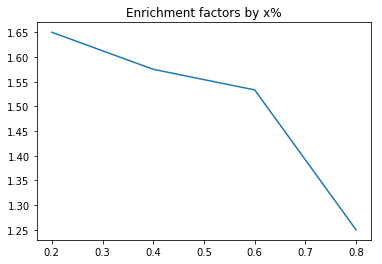

In [23]:
%pylab inline
import matplotlib.pyplot as plt

plt.plot(x, enr)
plt.title('Enrichment factors by x%')

### Metrics for high affinity  model

In [24]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K

metricData = shuffle(getChunks(1,'HA', up_dfFil,0,100))

In [25]:
enr = getMetrics(metricData, 'HA', mdict['HA'], 'aff')


Area under the ROC curve: 0.9009
BedROC score: 0.9368102788015124


Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Enrichment factors by x%')

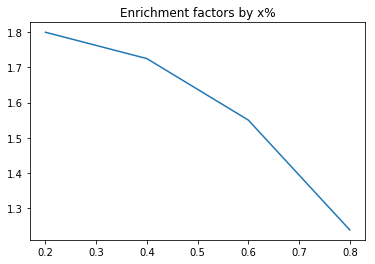

In [26]:
%pylab inline
import matplotlib.pyplot as plt

plt.plot(x, enr)
plt.title('Enrichment factors by x%')

### Discussion
##### Both our models had an AUC score of approximately 0 .9 indicating they both  have a strong ability to sperate the two classes they are being asked to classify, meaning the TNs of the sample dataset are mostly  distributed below the .5 threshold(keras deault), and the TP being mostly distributed above the .5 threshold. Both models had BEDROC scores over .8 representing the probability that a true positive will be ranked ahead of a false positive from a distribution determined by an alpha value, we use the value of 20 to follow the work of the paper listed below. The last metric collected is a list of enrichment factors which can be thought of as the ratio of the  fraction of true positives found over the top x% over the fraction of the sum of true positives over the total number of samples, yielding a value that demonstrates where the bulk of actives reside across a distribution. This measure can be leveraged for clinical purposes as it can be used to determine the number of actives in early samples. For this score we calculated the results for x: .2,.4,.6, and .8 . The curves generated by each model both yield the favorable outcome of a downward slope( both starting (>1) ) decreasing each iteration, indicating the majority of the actives for each respective model reside in the top percentiles.



http://rdkit.org/docs/source/rdkit.ML.Scoring.Scoring.html

https://www.dropbox.com/s/6je37ml475vg3ep/Srinivas2018ImplictDescriptorUnderReview.pdf?dl=0




### Secondary Analysis:  Add morgan fingerprints to input layer

#### Something smart about morgan finger prints (radius and folding stuff)
https://www.rdkit.org/docs/GettingStartedInPython.html

In [27]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K


mdict = {}
accs = []
losss = []
cols = ['HA','LA']
#shared layer across models
shared = GlobalMaxPooling1D()
for tag in cols:
    inputs = Input(shape=(2048 + 1024,), name='fps')
    x = Dropout(.3)(inputs)
    x = Reshape((96,32,))(x)
    x = Convolution1D(150, 10,padding='valid',activation='relu',strides=1)(x)
    x = shared(x)
    x = Dense(250)(x)
    x = Dropout(.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    
    mdict[tag] = Model(inputs=inputs, outputs=outputs)
    mdict[tag].compile(loss='binary_crossentropy', optimizer='ADAM', metrics=['binary_accuracy'])
    #Main difference is the second get chunks method which brings morgan fp data as well
    t = getChunks2(1,tag, up_dfFil,0,250) 
    t = shuffle(t)
    splt = int(len(t)*.8)
    t_train = t[:splt] #80
    t_test = t[splt:]#20
    trgt = tag
    mdict[tag].fit(prepBinAryData(t_train,'mo'), prepBinData(t_train, trgt), epochs=100, verbose=1)
    score = mdict[tag].evaluate(prepBinAryData(t_test, 'mo'), prepBinData(t_test, trgt), verbose=1)
    print(score)
    losss.append(score[0])
    accs.append(score[1])
    del x


Epoch 1/100
400/400 [==============================] - 1s 2ms/step - loss: 0.9276 - binary_accuracy: 0.5175
Epoch 2/100
400/400 [==============================] - 0s 584us/step - loss: 0.7531 - binary_accuracy: 0.5650
Epoch 3/100
400/400 [==============================] - 0s 584us/step - loss: 0.6805 - binary_accuracy: 0.5975
Epoch 4/100
400/400 [==============================] - 0s 607us/step - loss: 0.6188 - binary_accuracy: 0.6700
Epoch 5/100
400/400 [==============================] - 0s 602us/step - loss: 0.5863 - binary_accuracy: 0.6800
Epoch 6/100
400/400 [==============================] - 0s 578us/step - loss: 0.5532 - binary_accuracy: 0.6900
Epoch 7/100
400/400 [==============================] - 0s 745us/step - loss: 0.5353 - binary_accuracy: 0.7475
Epoch 8/100
400/400 [==============================] - 0s 735us/step - loss: 0.4917 - binary_accuracy: 0.7950
Epoch 9/100
400/400 [==============================] - 0s 681us/step - loss: 0.4492 - binary_accuracy: 0.8075
Epoch 10/100

400/400 [==============================] - 0s 651us/step - loss: 0.0335 - binary_accuracy: 0.9900
Epoch 48/100
400/400 [==============================] - 0s 670us/step - loss: 0.0125 - binary_accuracy: 0.9975
Epoch 49/100
400/400 [==============================] - 0s 701us/step - loss: 0.0119 - binary_accuracy: 1.0000
Epoch 50/100
400/400 [==============================] - 0s 576us/step - loss: 0.0112 - binary_accuracy: 0.9975
Epoch 51/100
400/400 [==============================] - 0s 701us/step - loss: 0.0123 - binary_accuracy: 0.9975
Epoch 52/100
400/400 [==============================] - 0s 680us/step - loss: 0.0108 - binary_accuracy: 1.0000
Epoch 53/100
400/400 [==============================] - 0s 755us/step - loss: 0.0077 - binary_accuracy: 1.0000
Epoch 54/100
400/400 [==============================] - 0s 654us/step - loss: 0.0060 - binary_accuracy: 1.0000
Epoch 55/100
400/400 [==============================] - 0s 641us/step - loss: 0.0098 - binary_accuracy: 0.9975
Epoch 56/100
4

In [28]:
for i in range(10):
    print("Batch "+str(i))
    mdls = shuffle(cols)
    for tag in mdls:
        print("Training: "+str(tag))
        t = getChunks2(1,tag, up_dfFil,0,100) # get chunk of data where tag == 1, of size 500 and 500 of not, w/o new column
        t = shuffle(t)
        splt = int(len(t)*.8)
        t_train = t[:splt] #80
        t_test = t[splt:]#20
        trgt = tag
        mdict[tag].fit(prepBinAryData(t_train,'mo'), prepBinData(t_train, trgt), epochs=10, verbose=1)
        score = mdict[tag].evaluate(prepBinAryData(t_test, 'mo'), prepBinData(t_test, trgt), verbose=1)
        print(score)
        losss.append(score[0])
        accs.append(score[1])

Batch 0
Training: LA
Epoch 1/10
160/160 [==============================] - 0s 581us/step - loss: 1.0080 - binary_accuracy: 0.7812
Epoch 2/10
160/160 [==============================] - 0s 663us/step - loss: 1.1497 - binary_accuracy: 0.7625
Epoch 3/10
160/160 [==============================] - 0s 623us/step - loss: 1.1137 - binary_accuracy: 0.7188
Epoch 4/10
160/160 [==============================] - 0s 617us/step - loss: 0.5975 - binary_accuracy: 0.7812
Epoch 5/10
160/160 [==============================] - 0s 582us/step - loss: 0.2405 - binary_accuracy: 0.9188
Epoch 6/10
160/160 [==============================] - 0s 748us/step - loss: 0.1221 - binary_accuracy: 0.9562
Epoch 7/10
160/160 [==============================] - 0s 630us/step - loss: 0.1248 - binary_accuracy: 0.9500
Epoch 8/10
160/160 [==============================] - 0s 605us/step - loss: 0.0598 - binary_accuracy: 0.9750
Epoch 9/10
160/160 [==============================] - 0s 614us/step - loss: 0.0610 - binary_accuracy: 0.975

160/160 [==============================] - 0s 680us/step - loss: 0.1346 - binary_accuracy: 0.9500
Epoch 9/10
160/160 [==============================] - 0s 690us/step - loss: 0.0980 - binary_accuracy: 0.9750
Epoch 10/10
40/40 [==============================] - 0s 173us/step
[0.5761261343955993, 0.7]
Batch 7
Training: HA
Epoch 1/10
160/160 [==============================] - 0s 606us/step - loss: 0.2519 - binary_accuracy: 0.9062
Epoch 2/10
160/160 [==============================] - 0s 692us/step - loss: 0.2717 - binary_accuracy: 0.8750
Epoch 3/10
160/160 [==============================] - 0s 621us/step - loss: 0.2970 - binary_accuracy: 0.8688
Epoch 4/10
160/160 [==============================] - 0s 561us/step - loss: 0.2546 - binary_accuracy: 0.8812
Epoch 5/10
160/160 [==============================] - 0s 573us/step - loss: 0.2104 - binary_accuracy: 0.9188
Epoch 6/10
160/160 [==============================] - 0s 680us/step - loss: 0.2004 - binary_accuracy: 0.9313
Epoch 7/10
160/160 [=====

Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


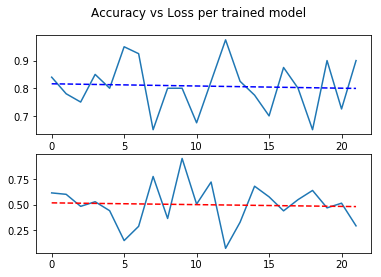

In [29]:
%pylab inline
import matplotlib.pyplot as plt

x = range(len(accs))

fig, axs = plt.subplots(2)
fig.suptitle('Accuracy vs Loss per trained model')

z = np.polyfit(x, accs, 1)
p = np.poly1d(z)
z1 = np.polyfit(x, losss, 1)
p1 = np.poly1d(z1)

axs[0].plot(x, accs)
axs[0].plot(x,p(x),"b--")
axs[1].plot(x, losss)
axs[1].plot(x,p1(x),"r--")

In [30]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K

metricData = shuffle(getChunks2(1,'HA', up_dfFil,0,100))
enr = getMetrics(metricData, 'HA', mdict['HA'],'mo')
x = [.2,.4,.6,.8]

Area under the ROC curve: 0.9465000000000003
BedROC score: 0.9824205955205387


Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Enrichment factors by x%')

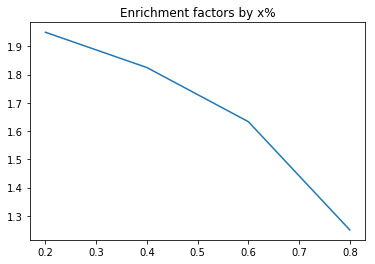

In [31]:
%pylab inline
import matplotlib.pyplot as plt

plt.plot(x, enr)
plt.title('Enrichment factors by x%')

In [32]:
#Reimport analysis dependencies
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.utils import shuffle
import keras
import scipy
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.layers import Input, Dense, concatenate, LSTM, Reshape, Dropout, Convolution1D, GlobalMaxPooling1D
import keras.backend as K

metricData = shuffle(getChunks2(1,'LA', up_dfFil,0,100))
enr = getMetrics(metricData, 'LA', mdict['LA'],'mo')

Area under the ROC curve: 0.849
BedROC score: 0.8213923000912753


Populating the interactive namespace from numpy and matplotlib


C:\Users\juan\anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Enrichment factors by x%')

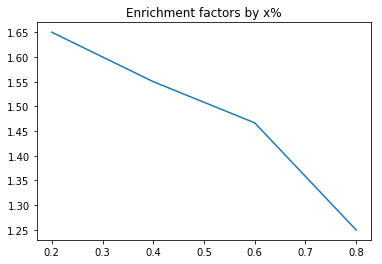

In [33]:
%pylab inline
import matplotlib.pyplot as plt

plt.plot(x, enr)
plt.title('Enrichment factors by x%')